In [1]:
import os
import sys

import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

import seaborn as sns 
from sklearn.decomposition import PCA

# Reading + Organizing the DATA: 

In [2]:
# The data comes from 
# os.listdir("../../project_data/")

['GSE131512_metaData.xlsx',
 'GSE131512_normalTPM.txt',
 'validation_bc_meta.xlsx',
 'pnas_patient_info.csv',
 'Homo_sapiens.GRCh38.111.gtf',
 'validation_normal_meta.xlsx',
 'gene_result_1.txt',
 'GSE131512_cancerTPM.txt',
 'gene_result.txt']

In [3]:
normal_df = pd.read_csv("../../project_data/GSE131512_normalTPM.txt", delimiter = '\t')
cancer_df = pd.read_csv("../../project_data/GSE131512_cancerTPM.txt", delimiter = '\t')
normal_df.shape, cancer_df.shape

((60675, 32), (60675, 96))

## Sample Metadata

In [4]:
# Metadata from the GEO page
filepath = "../../project_data/GSE131512_metaData.xlsx"
metadata = pd.read_excel(filepath)

# metadata for validation datasets from the github (not sure which samples it is referencing)
filepath = "../../project_data/validation_bc_meta.xlsx"
validation_bc_meta = pd.read_excel(filepath)
filepath = "../../project_data/validation_normal_meta.xlsx"
validation_normal_meta = pd.read_excel(filepath)

# additional metadata about cancer subtypes for the 96 cancer patients
filepath = "../../project_data/pnas_patient_info.csv"
patient_info = pd.read_csv(filepath)

In [5]:
# checking the shapes of the metadata to see if they fit expectation
# metadata.shape,patient_info.shape, validation_normal_meta.shape, validation_bc_meta.shape

((128, 3), (96, 30), (78, 3), (83, 4))

In [7]:
# Adding a chemo duration, and time from chemo end to recurrence fields
dt_end = pd.to_datetime(patient_info['datechemoend'], format="%d/%m/%Y")
dt_start = pd.to_datetime(patient_info['datechemostart'], format="%d/%m/%Y")
dt_recurrence = pd.to_datetime(patient_info['daterecurrence'], format="%d/%m/%Y")
patient_info['chemo_duration'] = (dt_end - dt_start).dt.days
patient_info['recurrence_time'] = (dt_recurrence - dt_end).dt.days

# Joining the two metadatas together)
metadata = pd.concat([metadata, 
                      patient_info[['cancertype', 'cancerstage_cat', 'chemo_duration', 'recurrence_time',  'chemo', 'recurStatus']]], 
                     axis=1, join='outer')
# setting the recurrence time for those that don't have recurrence to nan
metadata.loc[metadata.recurStatus == 'N', 'recurrence_time'] = np.nan
metadata.set_index("Sample name", inplace=True)
# writing the result out in a csv
metadata.to_csv('../data/metadata.csv')

# To make sure there are no nan's in the data
metadata.replace(np.nan, 0, inplace=True)

## Gene Metadata

In [9]:
gene_ids = normal_df.index.values

Using the GTF data to assign gene names 

In [10]:
with open("../../project_data/Homo_sapiens.GRCh38.111.gtf", 'r') as f: 
    gtf = f.readlines() 

gtf = [x for x in gtf if not x.startswith('#')]
gtf = [x for x in gtf if 'gene_id "' in x and 'gene_name "' in x]
gtf = list(map(lambda x: (x.split('gene_id "')[1].split('"')[0], x.split('gene_name "')[1].split('"')[0]), gtf))
gtf = dict(list(set(gtf)))

Defining the gene names based on gene ids

In [11]:
def catch(func, handle=lambda e: e, *args, **kwargs):
    try: 
        return func(*args, **kwargs)
    except Exception as e: 
        return "" 

In [12]:
gene_names = [catch(lambda : gtf[x]) for x in gene_ids]
gene_meta = pd.DataFrame({"gene_id": gene_ids, "gene_name" : gene_names}).set_index("gene_id")

gene_meta.shape

### Gene Terms

In [14]:
df_terms = pd.read_csv("../data/ncbi_bc_associations.txt", delimiter='\t')

# only looking for hunan genes
df_terms = df_terms.drop(df_terms[df_terms.Org_name != "Homo sapiens"].index)
# Getting the gene names
bc_genes = df_terms.Symbol.values
# adding the gene names to the meta data dataframe
gene_meta['is_bc'] = gene_meta.gene_name.isin(bc_genes)

# generating the subset genes based on the association genes
gene_subset = gene_meta[gene_meta.is_bc]

## Expression Data

In [138]:
# Overall Expression 
# gene_expression = pd.concat([cancer_df, normal_df], axis=1).T
sqmp_meta = metadata

# If I want to not include the non-cancer samples 
gene_expression = pd.concat([cancer_df], axis=1).T
samp_meta = metadata[:96]

# Subset Expression 
gene_expression_subset = gene_expression.T[gene_expression.columns.isin(gene_subset.index)].T

# PyWGCNA

## Run their pipeline

In [21]:
import PyWGCNA as wgc

Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  5483
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.256667  1.971111       0.614307  293.779209  294.685284   
1       2  0.093833 -0.860846       0.943779   55.606137   54.192257   
2       3  0.882025 -2.687892       0.956551   14.779688   12.454319   
3       4   0.96219 -2.525498       0.986957    5.085412    3.380055   
4       5   0.96635 -2.157355       0.993478    2.151014    1.056219   
5       6  0.967261 -1.938186       0.997438    1.069825    0.359025   
6       7  0.953359 -1.820381       0.992614    0.601698      0.1334   
7       8  0.939425 -1.738809       0.985935    0.370834    0.052772   
8       9  0.944776 -1.667742        0.98372    0.244664    0.021708   
9      10  0.948875 -1.608069        0.98675    0.169972    0.009444   
10

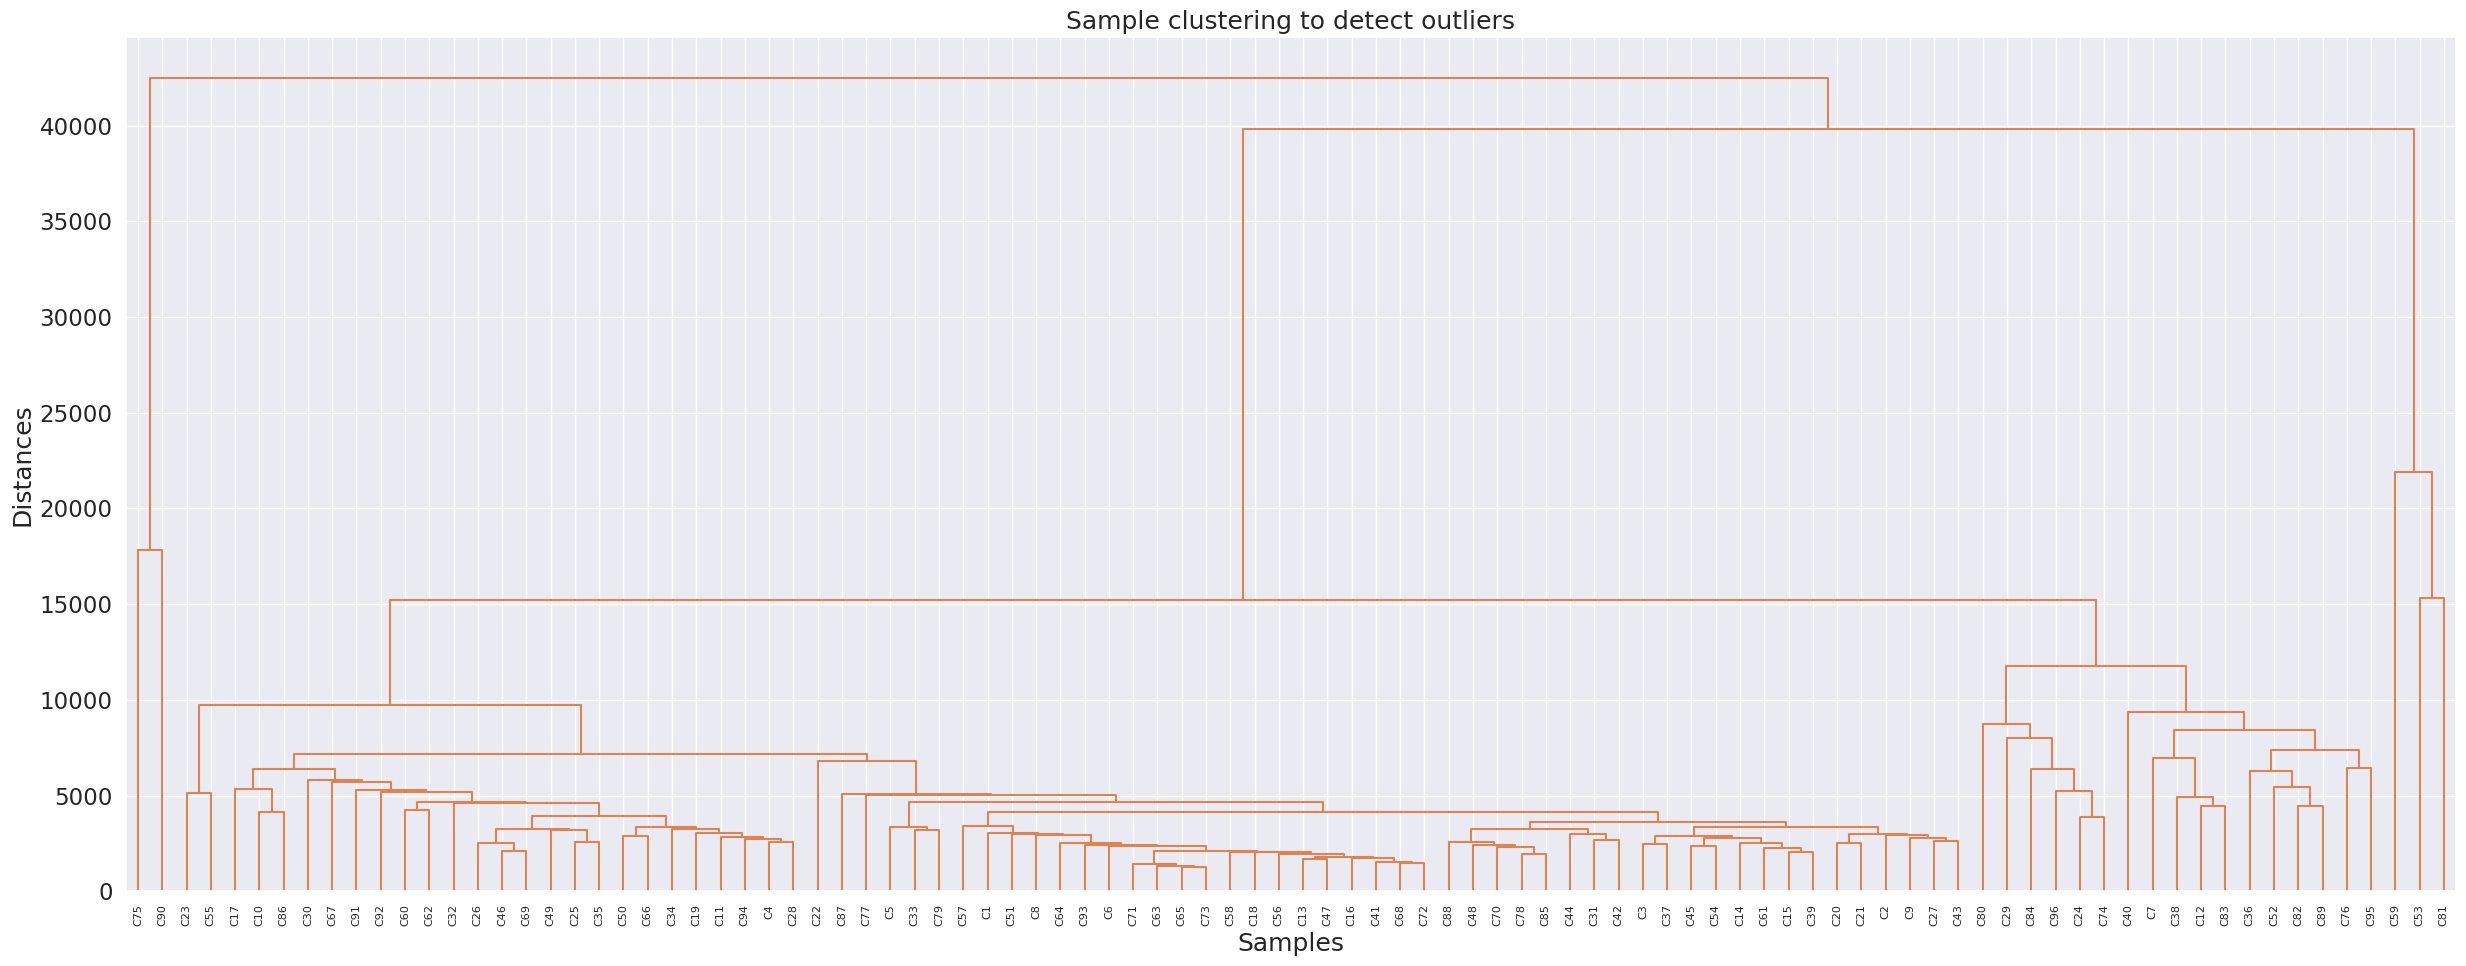

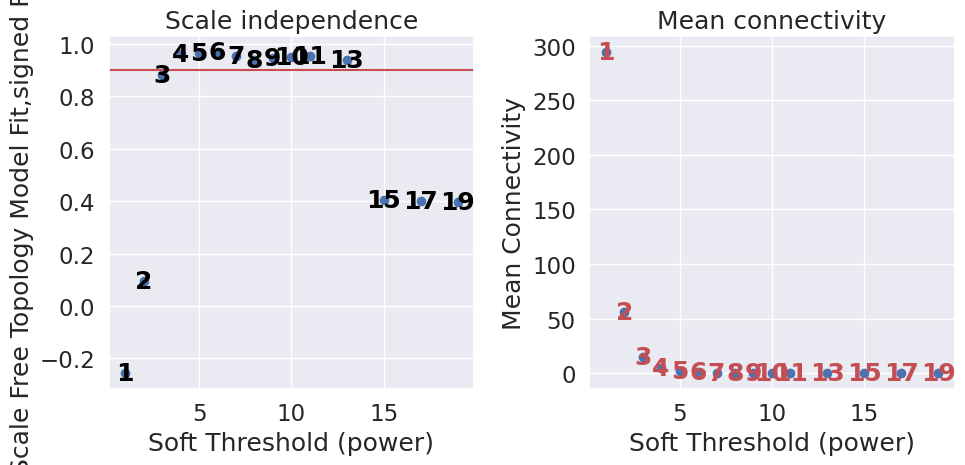

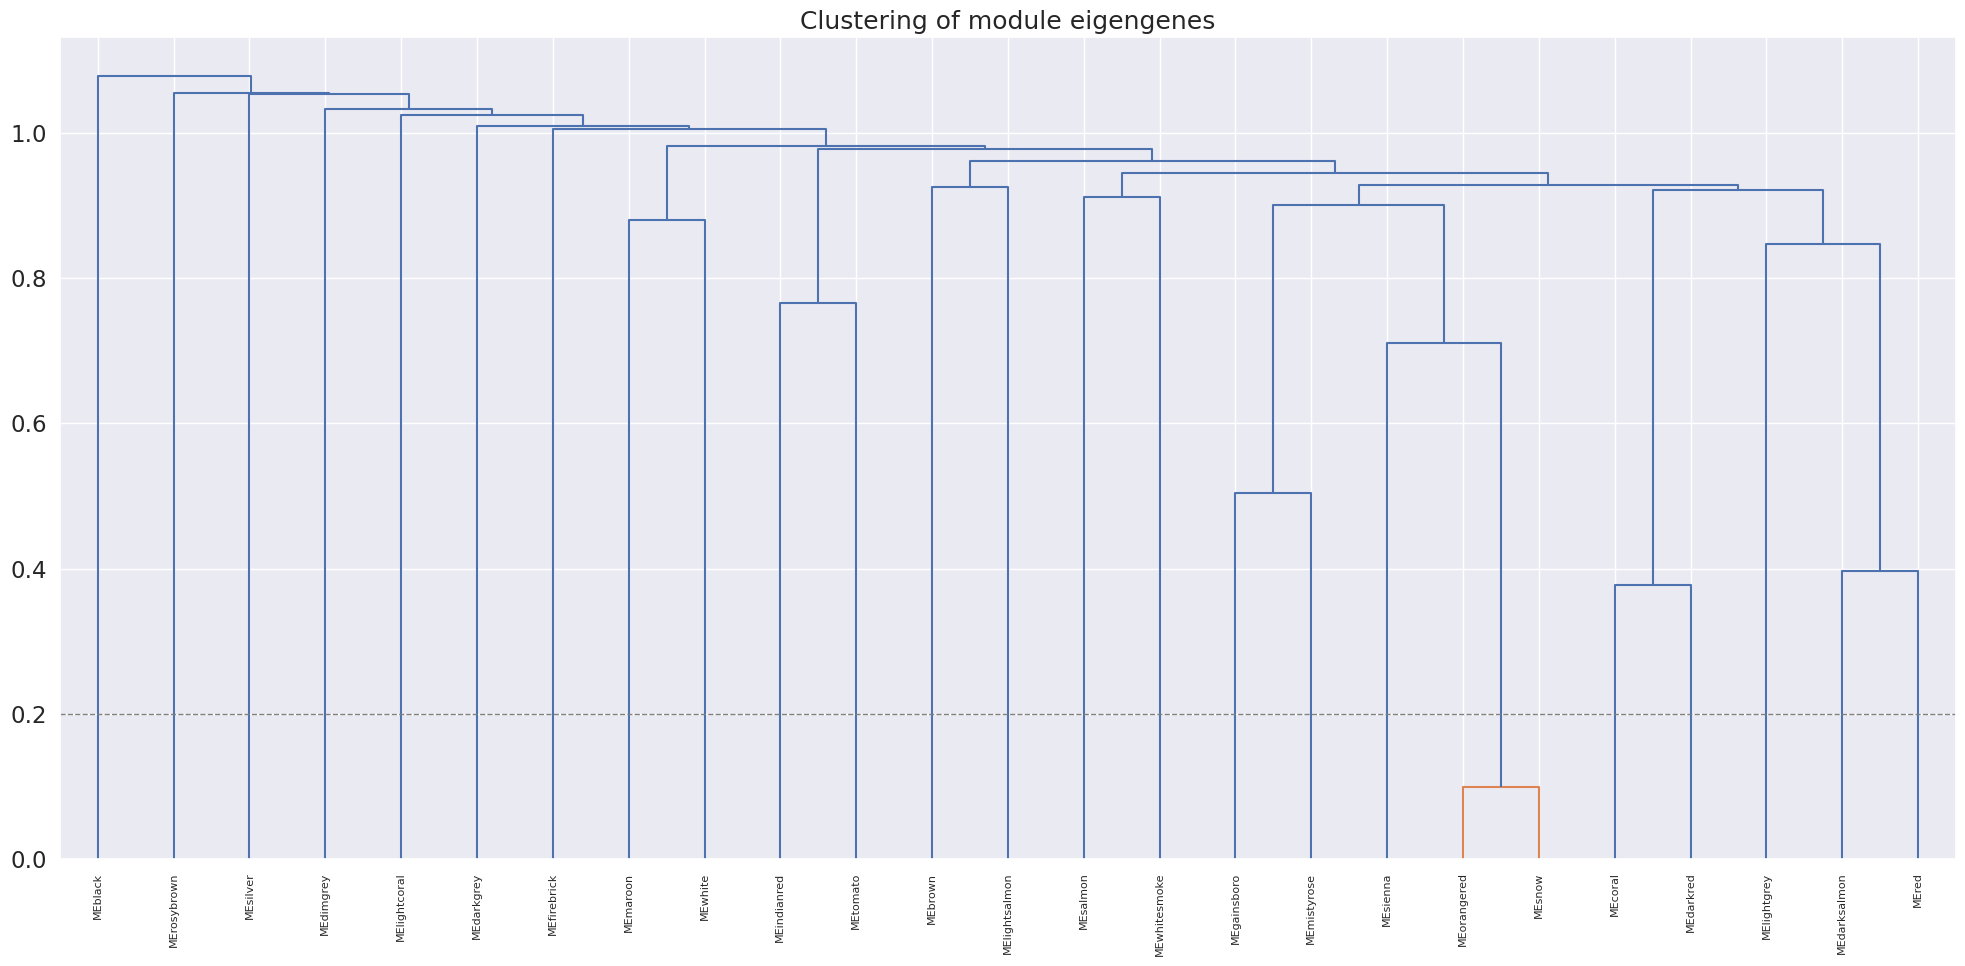

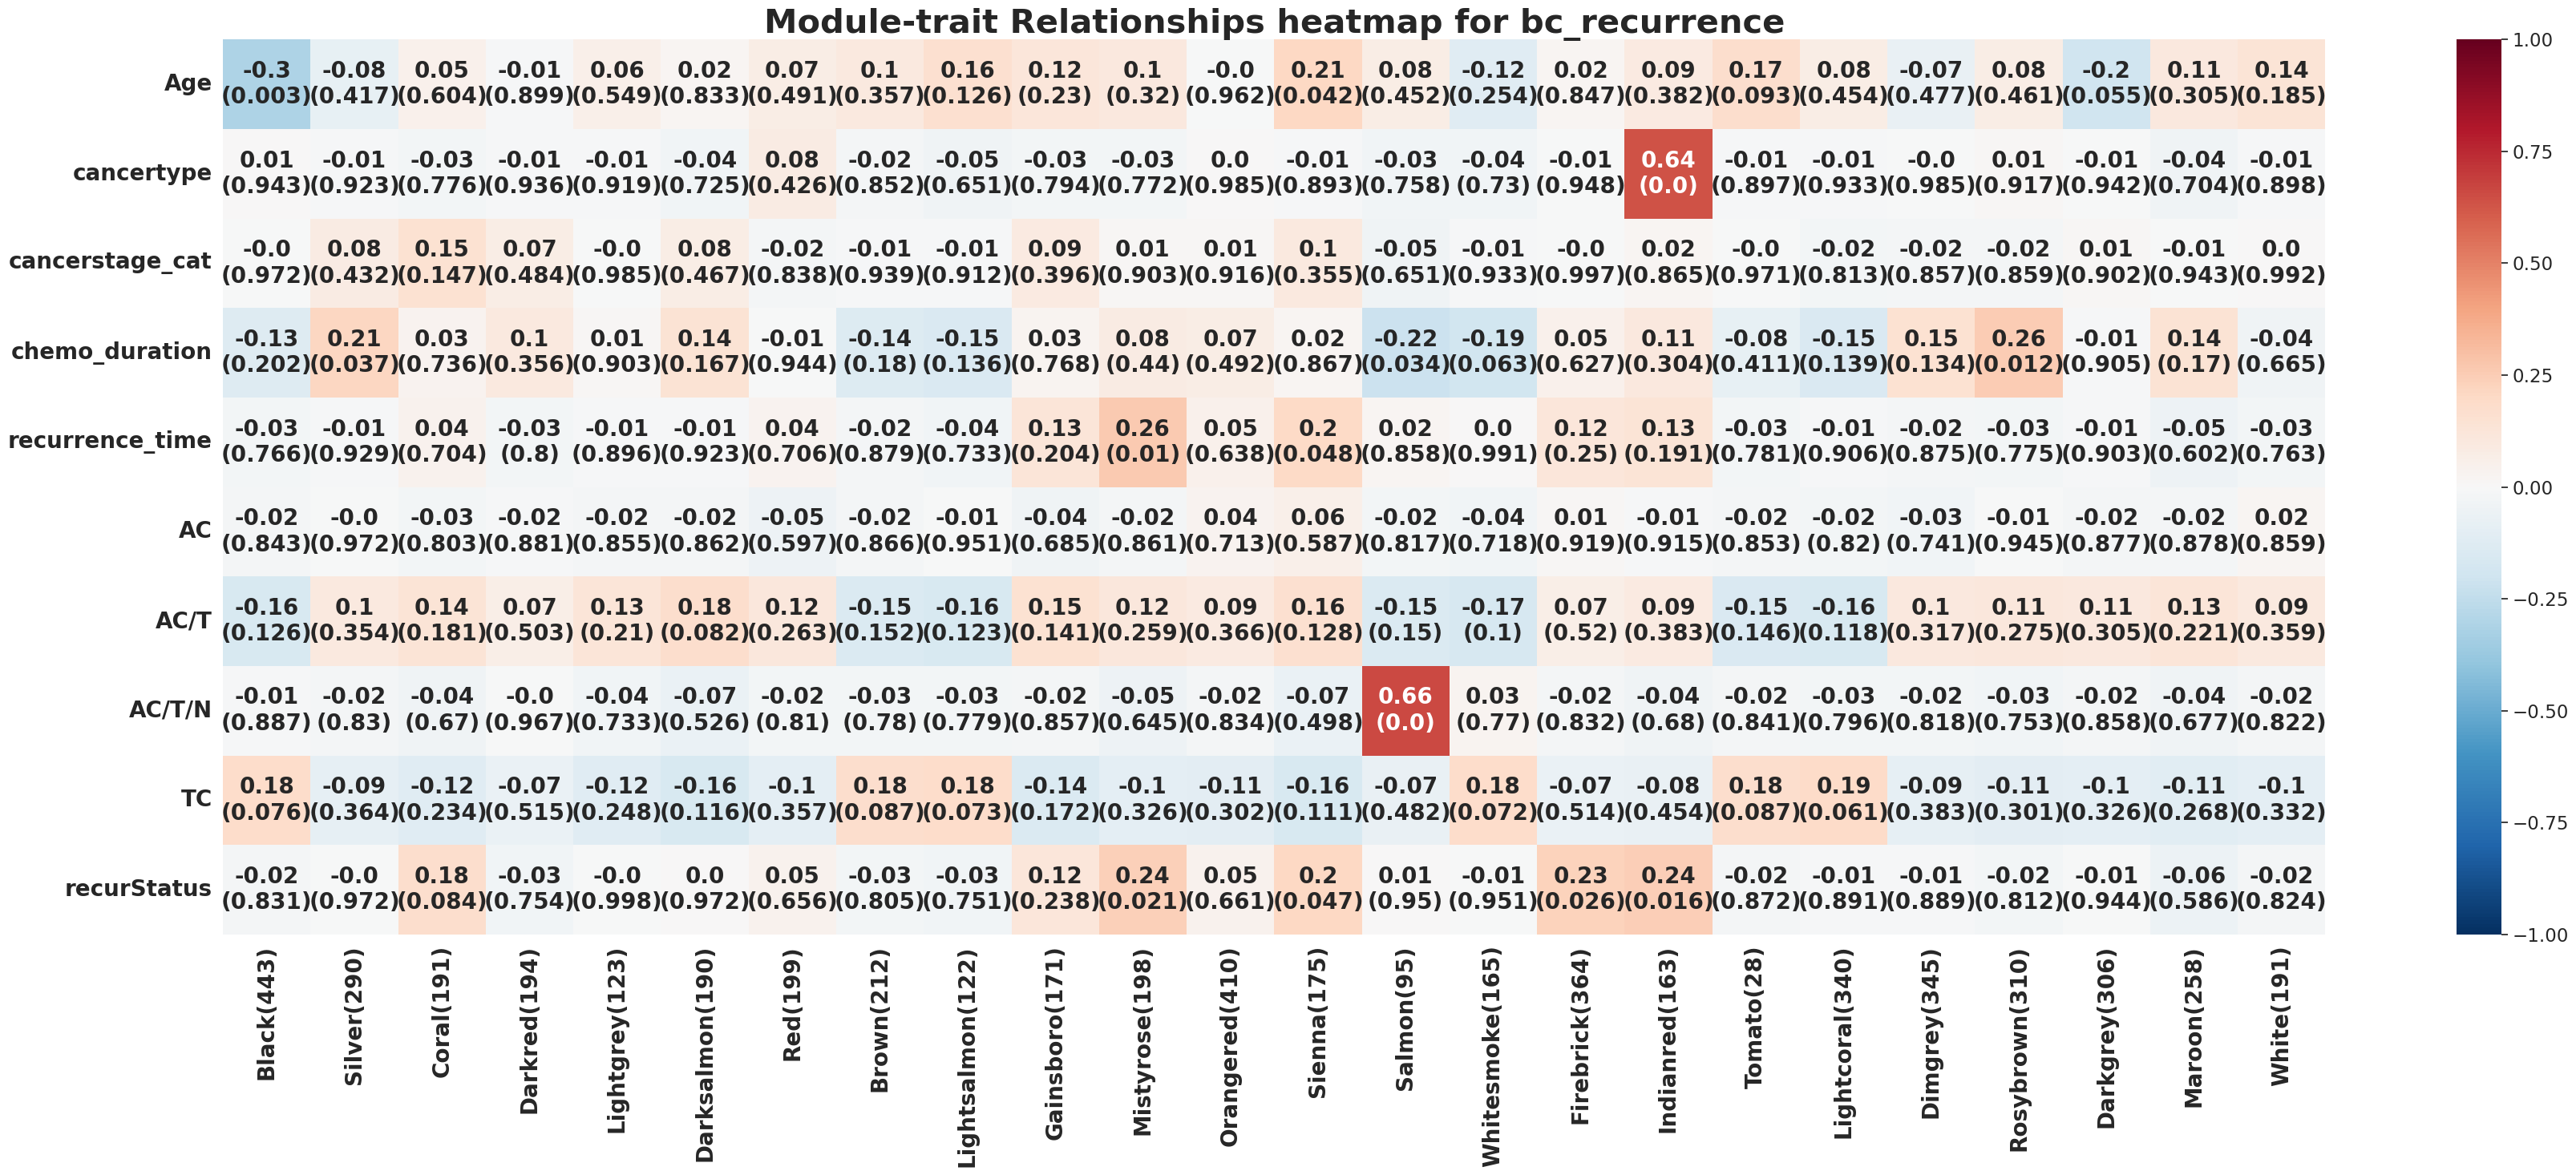

In [147]:
bc_obj = wgc.wgcna.WGCNA(name = "bc_recurrence", geneExp = gene_expression_subset, geneInfo=gene_subset, sampleInfo=samp_meta)
bc_obj.preprocess()
bc_obj.findModules()
bc_obj.analyseWGCNA()

## Get the modules 

In [192]:

# colors

In [193]:
%%capture

# Storing the cluster genes in a list
module_names = [c[2:] for c in bc_obj.datME.columns]
num_modules = len(module_names)

modules = []
for m in module_names[:num_modules]: 
    modules.append(bc_obj.top_n_hub_genes(moduleName=m, n=1000))

In [196]:
# Transforming the clsuter into a dictionary to store more information on reach cluster
cluster_info = {"cluster_id" : [],
                "gene_ids" : [],
                "gene_names" : [],
                "exp_var" : [],
                "eigen_vects" : []}
for i, df in enumerate(modules): 
    # display(df)
    cluster_info['cluster_id'].append(i) 
    cluster_info['gene_names'].append(df.gene_name.values)
    cluster_info['gene_ids'].append(df.index.values)
    # break

## Get the Module Eigenvectors

In [103]:
from scipy.stats import zscore

In [197]:
# To calculate and store the eigen vectors for each cluster

# Iterating over each cluster 
for row in cluster_info['cluster_id']:
    # getting the expression matrix for that cluster
    ids = cluster_info['cluster_id'][row]
    gene_ids = cluster_info['gene_ids'][row]
    sub_gene_expr = gene_expression[gene_ids]
    sub_gene_expr = zscore(sub_gene_expr.T).T
    
    # performing PCA on the cluster expression matrix
    pca = PCA()
    pca.fit(sub_gene_expr)
    # adding the eigen vectors to the dictionary
    cluster_info['exp_var'].append(pca.explained_variance_ratio_[:5])
    cluster_info['eigen_vects'].append(pca.components_[:5])

In [198]:
# To calculate the transformation matrix to turn the data into its cluster projections 
transformation = []

# Iterating over each cluster 
for row in cluster_info['cluster_id']:
    gene_ids = cluster_info['gene_ids'][row]
    for i in range(5): 
        eigen = cluster_info['eigen_vects'][row][i]
        e_vect = []
        
        for g in gene_expression_subset.columns: 
            if g in gene_ids: 
                idx = np.where(gene_ids == g)[0]
                e_vect.append(eigen[idx[0]])            
            else:
                e_vect.append(0)
        # print(e_vect)
        e_vect = np.asarray(e_vect)
        transformation.append(e_vect)

np_tran = np.asarray(transformation)
np_tran.shape

(120, 5531)

## Transform dataset

In [199]:
zscore(gene_expression_subset, axis=0)

,ENSG00000000971,ENSG00000001084,ENSG00000001167,ENSG00000001497,ENSG00000001617,ENSG00000001626,ENSG00000002016,ENSG00000002330,ENSG00000002549,ENSG00000002586,...,ENSG00000280997,ENSG00000281103,ENSG00000281131,ENSG00000281183,ENSG00000281189,ENSG00000281358,ENSG00000281450,ENSG00000281691,ENSG00000282608,ENSG00000282961
C1,1.103652,-0.356913,-0.317732,-0.385503,0.305098,1.148419,0.159717,0.918868,2.711204,-0.348071,...,-0.204916,-0.708841,-0.730158,-0.621533,-0.798544,-0.155235,-0.242238,-0.273355,-1.029040,-0.515678
C2,0.168452,-1.017123,2.153699,0.399468,-0.066022,-0.252629,-0.577983,0.503424,0.609588,-1.035796,...,0.439755,-0.553762,-0.730158,-0.964650,-0.306280,-0.155235,-0.242238,-0.273355,-0.470487,-1.354960
C3,-0.633232,-0.009463,-0.091511,-0.557866,0.273347,0.179896,0.766170,2.301661,-0.398416,1.193820,...,4.000622,-0.835376,1.568979,0.374265,-0.798544,-0.155235,-0.242238,-0.273355,1.005348,1.283174
C4,0.219791,-0.609883,-0.519159,0.362333,0.591312,0.647599,0.651695,0.174701,-0.260799,-1.122871,...,-0.218286,0.519244,0.305245,0.375290,-0.462110,2.778778,-0.242238,-0.273355,0.497919,-0.438708
C5,3.488651,3.557911,-1.069954,0.461378,-0.243715,-0.172381,-0.264158,-0.535010,-0.278337,0.245796,...,-0.769055,0.810060,4.168972,-0.172140,-0.002604,-0.155235,-0.242238,-0.273355,0.325644,1.179574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C92,-1.069081,-1.317460,1.466424,-0.111727,-0.993664,1.331408,0.114079,-0.535010,-1.137524,0.312332,...,-0.769055,-1.070751,-0.730158,-0.964650,-0.217572,-0.155235,6.213635,-0.273355,-1.029040,2.453517
C93,1.341884,-0.056434,0.791916,0.666579,1.052017,-0.140680,-0.926436,-0.535010,-0.167784,-0.790924,...,-0.515176,0.232208,1.497116,-0.964650,0.131941,-0.155235,-0.242238,-0.273355,1.434461,-1.080055
C94,0.154748,0.236347,1.598377,-0.873508,1.463430,0.466419,0.766065,-0.535010,1.092446,1.239216,...,-0.769055,0.298624,-0.395757,-0.964650,2.787145,-0.155235,-0.242238,8.268057,0.820298,-0.705600
C95,-0.385292,0.531885,2.648766,0.626964,-0.993664,-0.794549,-0.530744,-0.535010,1.132801,-1.110457,...,-0.181918,1.377563,-0.362234,-0.250440,-0.798544,-0.155235,-0.242238,-0.273355,-1.029040,0.864131


In [201]:
labels = [f"C{i+1}_P{j+1}" for i in range(num_modules) for j in range(5)]
dataset = zscore(gene_expression_subset, axis=1).values @ np_tran.T
df_dataset = pd.DataFrame(dataset, columns = labels, index = gene_expression_subset.index)

### Write to Pickle

In [206]:
with open("../data/large_transformed_cancer_dataset.pandas", 'wb') as f: 
    pickle.dump(df_dataset, f)

## Validate clusters with PCA

In [202]:
df_dataset

,C1_P1,C1_P2,C1_P3,C1_P4,C1_P5,C2_P1,C2_P2,C2_P3,C2_P4,C2_P5,...,C23_P1,C23_P2,C23_P3,C23_P4,C23_P5,C24_P1,C24_P2,C24_P3,C24_P4,C24_P5
C1,-0.921765,-0.556193,-0.629827,-0.450109,-0.071370,-0.990374,-0.665371,-0.949960,-1.174456,2.237556,...,1.499016,2.344306,0.551368,0.796731,-1.540537,-0.905969,0.169925,-0.250186,0.187096,0.556932
C2,1.597816,-0.264433,-1.415401,0.270286,1.410517,2.377227,-3.539536,-1.860566,1.216495,-0.593119,...,-0.879272,0.793350,-0.154688,0.214278,-0.002516,-0.628309,-0.004150,0.026663,0.134021,-0.405007
C3,-0.310246,0.290826,0.753565,-0.653757,2.690805,-1.001325,-0.572561,0.064508,0.128429,-0.117783,...,-0.478551,0.215920,0.323849,-0.873501,1.630385,-1.000565,0.080912,0.940906,-0.643758,-0.216572
C4,-0.430115,-0.720903,-0.383989,0.117219,0.188774,0.009289,-0.350790,-0.662624,-0.959848,1.531524,...,-0.420590,0.357916,-0.170718,0.020805,0.065394,-0.613700,0.118411,0.003979,0.055151,0.020754
C5,0.923231,-1.431746,-1.329202,0.924906,0.622133,-1.115829,-0.690476,0.109958,0.227891,0.404493,...,1.298186,-1.368899,-3.210511,5.415340,0.623126,-1.137929,0.462730,-0.281995,0.569041,0.041344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C92,-0.320613,0.461955,-0.582786,0.109446,-0.008572,-1.240458,-0.604293,0.240435,-0.094114,-0.398430,...,-0.278226,0.186396,-0.089383,-0.118268,-0.167010,-0.350041,0.085382,0.111438,0.092655,0.022135
C93,0.605649,0.161337,7.903295,5.512944,5.126955,5.022970,13.434147,-0.896978,15.712981,8.283787,...,-1.217403,1.306644,-1.358685,0.319377,0.251723,-1.123229,1.715082,-0.910965,1.042638,-1.505937
C94,-0.488420,-0.545313,-0.699208,0.382110,0.157083,-0.655170,-0.391050,0.048601,0.012852,0.227719,...,-0.483191,0.369500,-0.144343,-0.057205,-0.122526,-0.249779,-0.754769,-1.001146,-0.014126,-1.169314
C95,-0.178855,-0.217659,-0.066696,0.086999,0.029728,0.717613,-0.566253,2.165469,-0.333505,0.548632,...,-0.237904,0.155493,-0.018219,0.033863,-0.038579,-0.304669,-0.105914,0.709657,-0.436390,-0.133128


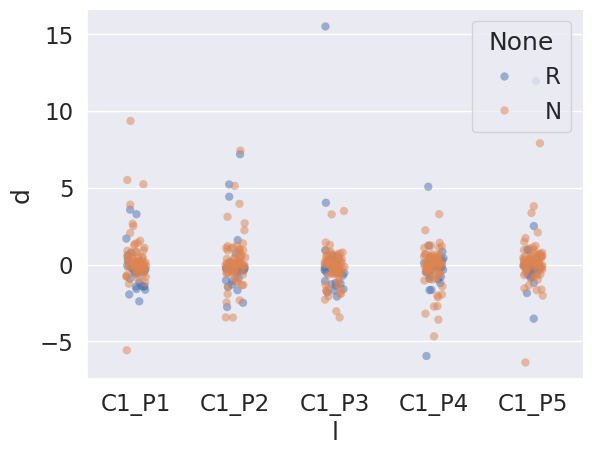

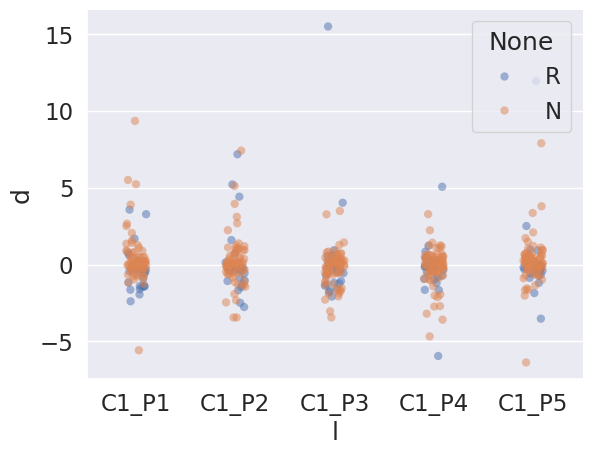

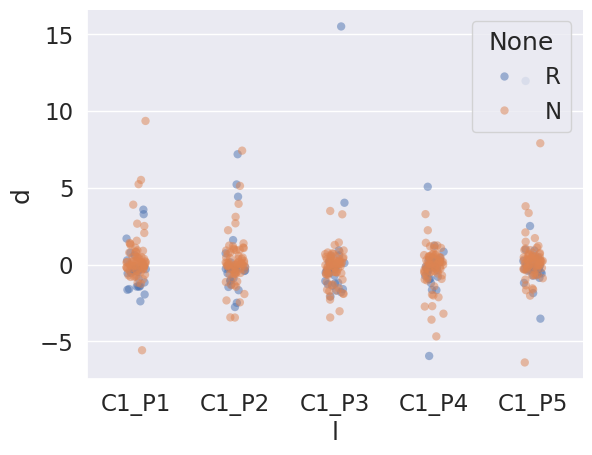

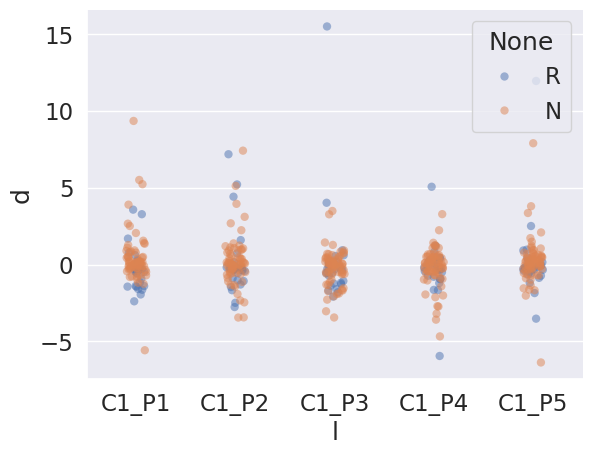

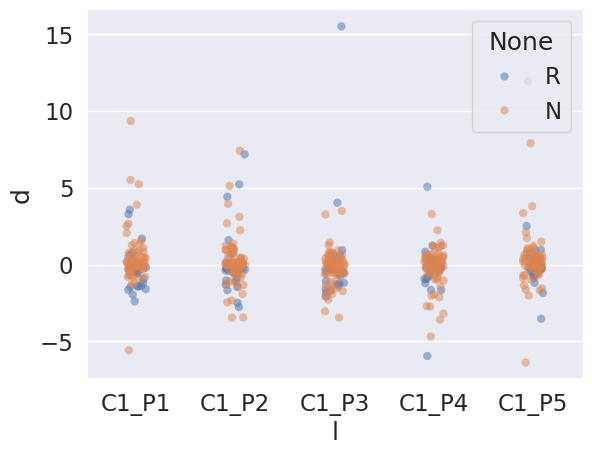

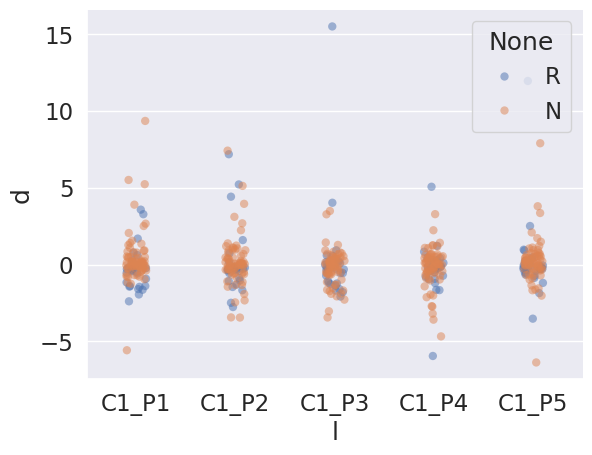

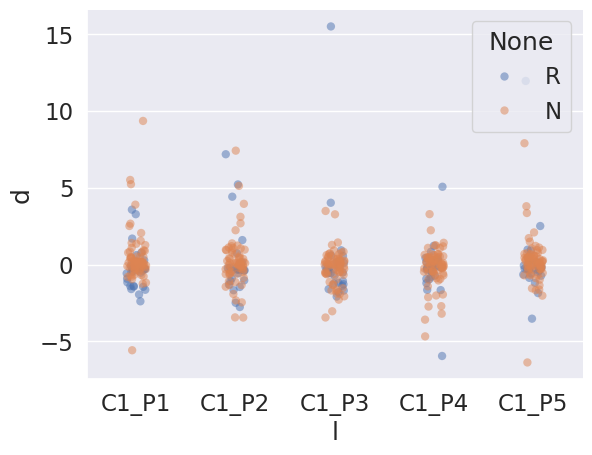

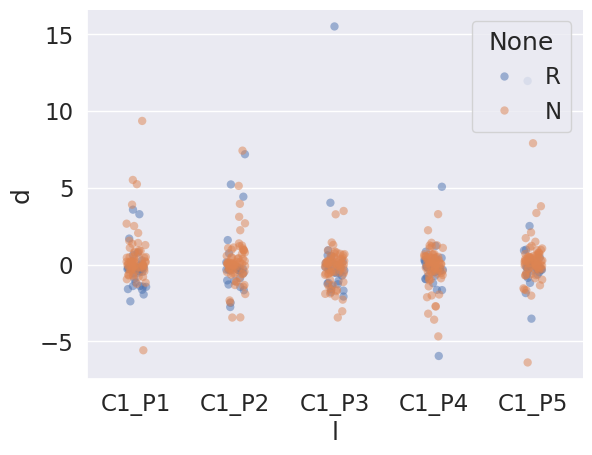

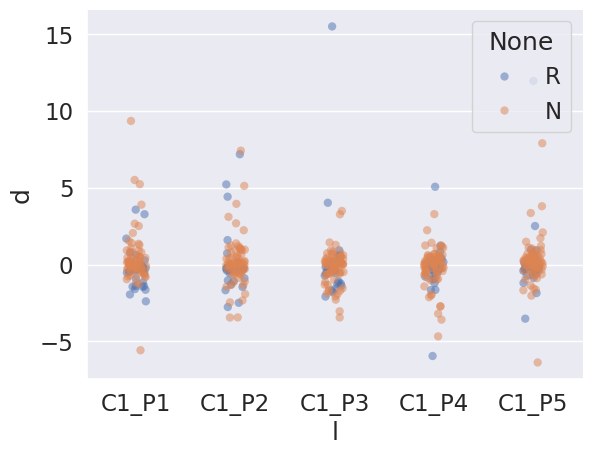

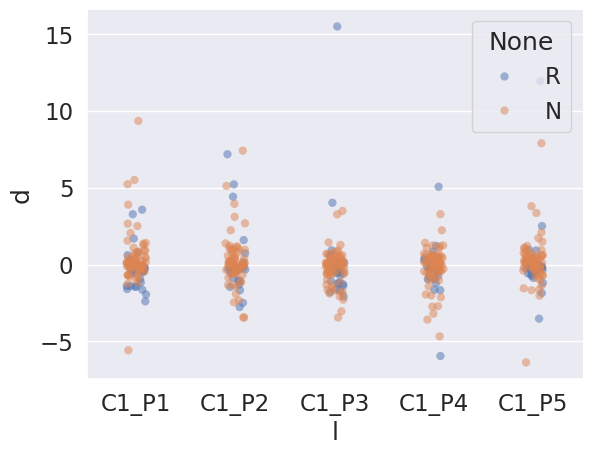

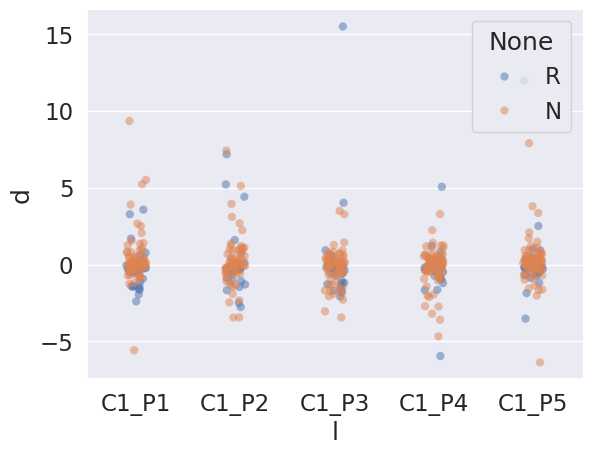

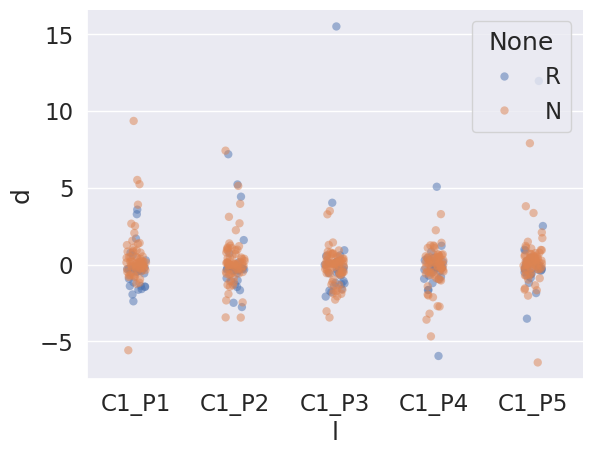

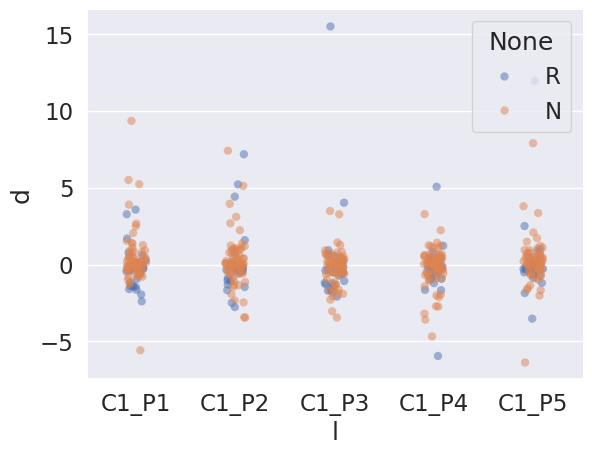

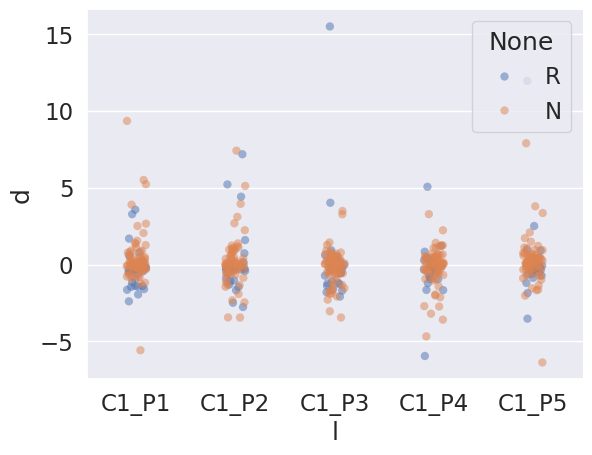

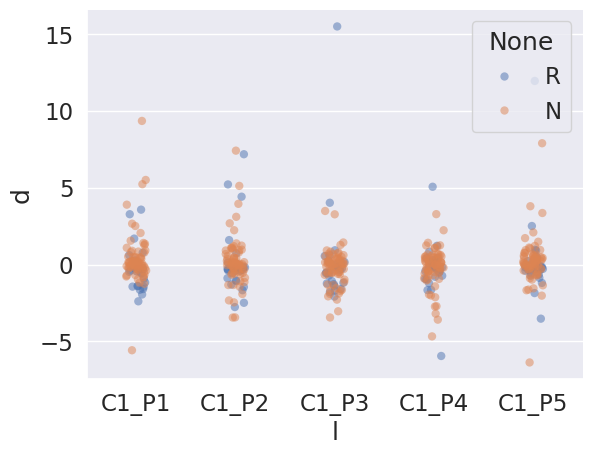

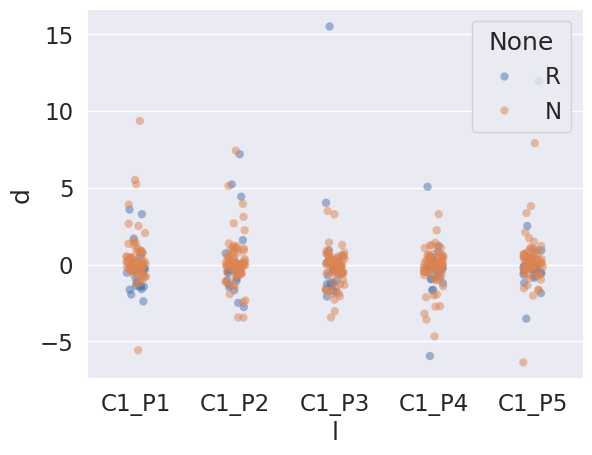

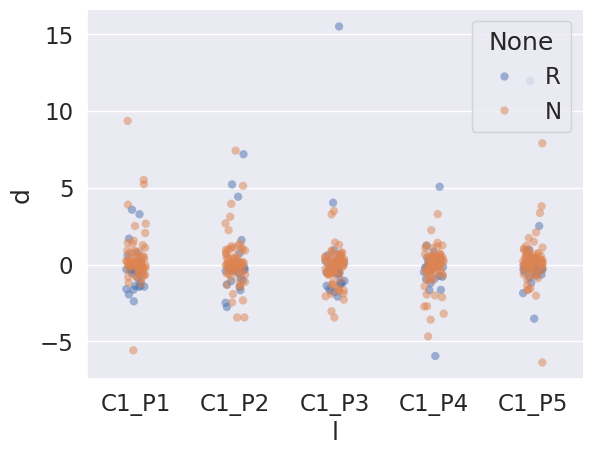

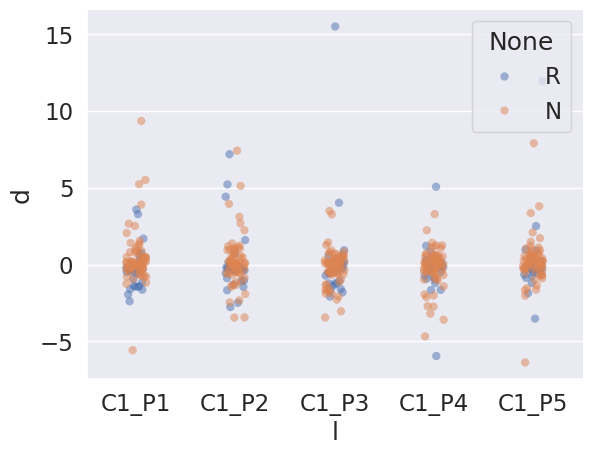

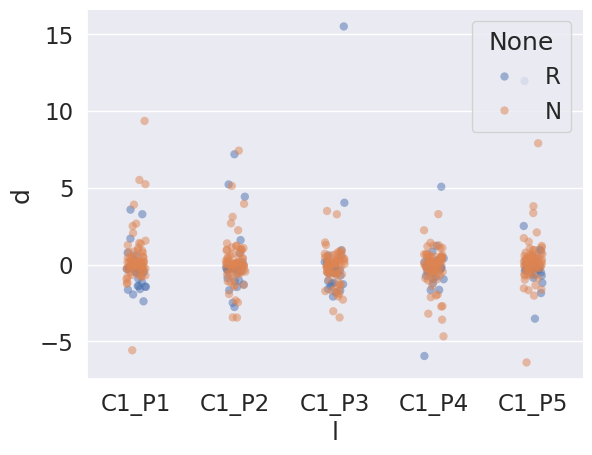

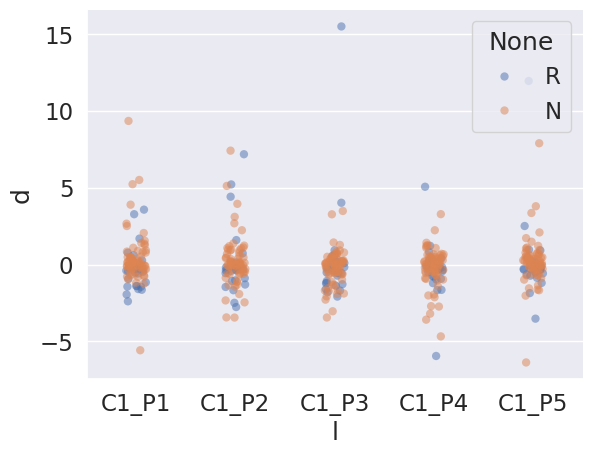

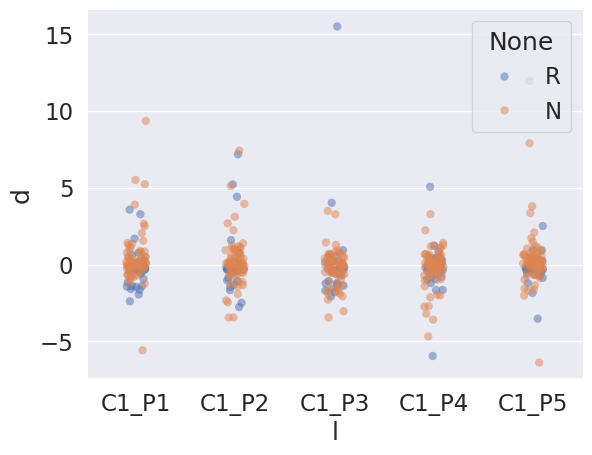

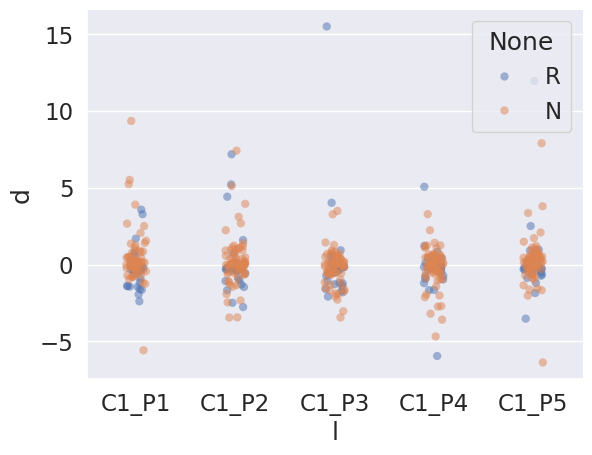

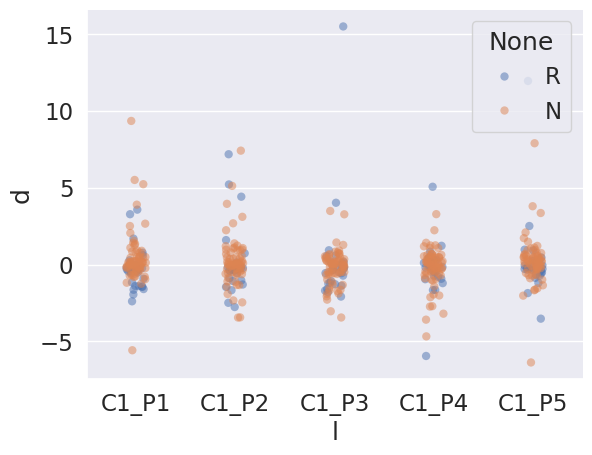

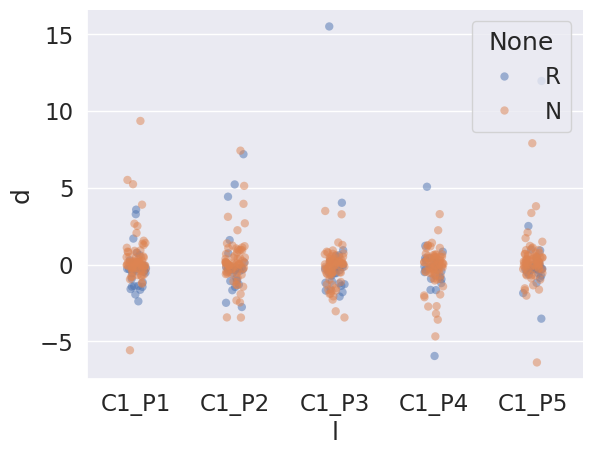

In [205]:
num_modules=24
for i in range(num_modules): 
    data_tog = []
    labels_tog = []
    for i, c in enumerate(dataset.T[:5]): 
        data_tog.append(c)
    data_tog=np.asarray(data_tog).flatten()
    labels_tog = np.asarray(labels[:5] * len(c))
    sample_names = np.asarray([[x]*5 for x in samp_meta.recurStatus.values]).flatten()
    df_tt = pd.DataFrame({"d" : data_tog, "l" : labels_tog}, index = sample_names)
    sns.stripplot(x = "l", y = "d", hue = df_tt.index, data = df_tt, 
                  edgecolor='none', alpha=0.5, jitter = True, size = 6)
    sns.despine()
    plt.show()